# Feature Engineering 

The purpose of this notebook is to implement and analyse different feature vectors: HOGs, LBPs, LBP-based implementation of delta-T, and segmentation features as described in the paper. The notebook also compares the performance of different features to the automated version of a human-evaluation method as described in Gonzalez (2011) using a vanilla LogReg model.  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Histogram-of-Oriented-Gradients" data-toc-modified-id="Histogram-of-Oriented-Gradients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Histogram of Oriented Gradients</a></span><ul class="toc-item"><li><span><a href="#Dimensionality-Reduction-Techniques" data-toc-modified-id="Dimensionality-Reduction-Techniques-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dimensionality Reduction Techniques</a></span><ul class="toc-item"><li><span><a href="#Locality-Preserving-Projections" data-toc-modified-id="Locality-Preserving-Projections-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Locality Preserving Projections</a></span></li><li><span><a href="#PCAs-with-different-Kernels" data-toc-modified-id="PCAs-with-different-Kernels-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>PCAs with different Kernels</a></span><ul class="toc-item"><li><span><a href="#RBF" data-toc-modified-id="RBF-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>RBF</a></span></li><li><span><a href="#Poly" data-toc-modified-id="Poly-1.1.2.2"><span class="toc-item-num">1.1.2.2&nbsp;&nbsp;</span>Poly</a></span></li><li><span><a href="#Sigmoid" data-toc-modified-id="Sigmoid-1.1.2.3"><span class="toc-item-num">1.1.2.3&nbsp;&nbsp;</span>Sigmoid</a></span></li><li><span><a href="#Cosine" data-toc-modified-id="Cosine-1.1.2.4"><span class="toc-item-num">1.1.2.4&nbsp;&nbsp;</span>Cosine</a></span></li><li><span><a href="#Linear-(Ordinary)-PCA" data-toc-modified-id="Linear-(Ordinary)-PCA-1.1.2.5"><span class="toc-item-num">1.1.2.5&nbsp;&nbsp;</span>Linear (Ordinary) PCA</a></span></li></ul></li><li><span><a href="#FastICA" data-toc-modified-id="FastICA-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>FastICA</a></span></li></ul></li></ul></li><li><span><a href="#Local-Binary-Patterns" data-toc-modified-id="Local-Binary-Patterns-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Local Binary Patterns</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#LBP-Based-Delta-Ts" data-toc-modified-id="LBP-Based-Delta-Ts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LBP-Based Delta-Ts</a></span></li><li><span><a href="#Segmentation-Features" data-toc-modified-id="Segmentation-Features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Segmentation Features</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></span></li></ul></div>

In [1]:
# Environment Setup
from utils import *
from setup import *

Progress: [####################] 100.0%
Added 1048 patients


## Histogram of Oriented Gradients

In [2]:
def get_hog(temps,
            orientations=4,
            pixels_per_cell=(12,12),
            cells_per_block=(4,4),
            block_norm='L1-sqrt',
            vis=False):
    """Compute HOG vector features of the exploration ROIs.

    If exploration is a patient ID, the HOGs are computed on the patient's
    latest exploration's ROIs.

    Parameters
    ----------
    exploration: string or list
                 Patient ID or
                 list of ROI-masked temperatures in l, lf, r, rl order.
    orientations: int
                  Number of orientation bins.
    pixels_per_cell: 2-tuple (int, int), optional
                     Size (in pixels) of a cell.
    cells_per_block: 2-tuple (int, int), optional
                     Number of cells in each block.
    block_normstr: {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}, optional
                   Block normalization method.
    visualize: bool optional
               Also return an image of the HOG.
               For each cell and orientation bin, the image contains a
               line segment that is centered at the cell center,
               is perpendicular to the midpoint of the range of angles spanned
               by the orientation bin, and has intensity proportional to the
               corresponding histogram value.

    Returns
    -------
    hog_features: list[nd array]
                  List of HOG descriptors for the input images:
                  a 1D (flattened) array is returned.
    """
    # Make sure the exploration is valid
    if len(temps) != 4:
        raise ValueError(f'{temps} is not a valid exploration')
    
    hog_features = []
    if vis:
        hog_visuals = []
        for temp in temps:
            # Get HOG feature vector + visuals
            temp = np.nan_to_num(temp)
            
            hog_feature_vect, hog_vis = hog(temp,orientations,
                                            pixels_per_cell,
                                            cells_per_block,
                                            block_norm,
                                            visualize=vis)
            hog_features.append(hog_feature_vect)
            hog_vis[hog_vis==0]=np.nan
            hog_visuals.append(hog_vis)
        return hog_features, hog_visuals
    else:
        for temp in temps:
            temp = np.nan_to_num(temp)
            # Get HOG feature vector
            hog_feature_vect = hog(temp,
                                   orientations=orientations,
                                   pixels_per_cell=pixels_per_cell,
                                   cells_per_block=cells_per_block,
                                   block_norm=block_norm,
                                   visualize=vis,
                                   multichannel=False,
                                   feature_vector=True)
            hog_features.append(hog_feature_vect)
        return hog_features

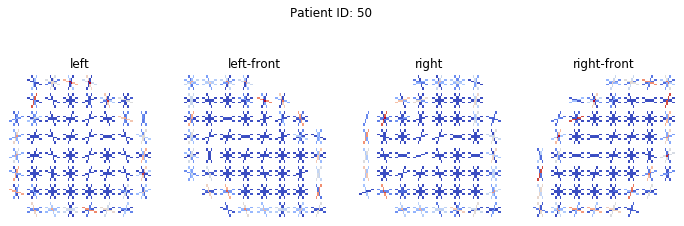

In [3]:
# Plot example HOGs
idx = np.random.randint(0,len(temps))
_, vis_hogs = get_hog(temps[idx], vis=True)
np.array(vis_hogs).shape

plot_exp(vis_hogs, IDs[idx])

In [4]:
# Extract feature vector
hogs = [np.array(get_hog(temp)).flatten() for temp in temps]
hog_data = pd.DataFrame(hogs)
hog_data.index = IDs
hog_data['BIRADS'] = explorations.BIRADS.values

# Subset positive indices
pos_ids = hog_data.index[hog_data.BIRADS>3]

In [5]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(hog_data.loc[:, hog_data.columns != 'BIRADS'], 
                                                    hog_data.BIRADS)
y_train_bi = np.where(y_train>3,1,0)
y_test_bi = np.where(y_test>3,1,0)

### Dimensionality Reduction Techniques

In [6]:
# Helper functions
def get_components(method, n_comp, 
                   train_set, test_set,
                   name, kernel=None):
    ''' Perform dimensionality reduction.


    Inputs & Parameters
    ----------
    method: object
                 Name of the dimensionality
                 reduction method (KernelPCA, 
                                   FastICA, 
                                   LocalityPreservingProjection)
    n_comp: int
               Number of output components

    train_set: pandas DataFrame
             Training data with the HOG feature vector
    test_set: pandas DataFrame
             Testing data with the HOG feature vector
    name: str
            Name of the dimensionality reduction method
    kernel: str (optional)
            A kernel that is used for kernel PCA methods


    Outputs
    -------
    two transformed dataframes: one for train, one for test
    '''
    if kernel:
        dim_red = method(n_components=n_comp, kernel=kernel)
    else:
        dim_red = method(n_components=n_comp)
    
    # Make sure there is no data leakage
    train_comps = dim_red.fit_transform(train_set)
    test_comps = dim_red.transform(test_set)
    
    df_train = pd.DataFrame(train_comps, 
                            columns =[name +str(i+1) for i in range(len(train_comps[0]))])
    df_test = pd.DataFrame(test_comps, 
                           columns =[name +str(i+1) for i in range(len(test_comps[0]))])
    df_test.index = test_set.index.values
    df_train.index = train_set.index.values
    df_test.index.name = 'pid'
    df_train.index.name = 'pid'

    return df_train, df_test

In [7]:
def get_stats(healthy, cancer):
    ''' Get dataframes with healthy and cancer patients.


    Inputs
    ----------
    method: object
                 Name of the dimensionality
                 reduction method (KernelPCA, 
                                   FastICA, 
                                   LocalityPreservingProjection)
    healthy: pandas dataframe
               Dataframe with healthy patients' data

    cancer: pandas dataframe
            Dataframe with cancer patients' data

    Returns
    -------
    a dataframe with t-values and statistics for each feature
    '''
    features = [feat for feat in healthy.columns]
    sd_h = [np.std(healthy[feat]) for feat in healthy.columns]
    sd_c = [np.std(cancer[feat]) for feat in healthy.columns]
    mean_h = [np.mean(healthy[feat]) for feat in healthy.columns]
    mean_c = [np.mean(cancer[feat]) for feat in healthy.columns]
    t = [ttest_ind(healthy[feat], cancer[feat])[0] for feat in healthy.columns]
    p = [ttest_ind(healthy[feat], cancer[feat])[1] for feat in healthy.columns]

    statistics = pd.DataFrame({'Feature Name':features,
                               'Mean Healthy':mean_h,
                               'Mean Cancer':mean_c,
                               'SD_Healthy':sd_h,
                               'SD_Cancer':sd_c,
                               'p-value':p, 
                               't-value':t})
    statistics = statistics.reindex(statistics['t-value'].abs().sort_values(ascending=False).index)
    return statistics

In [8]:
# def performance(X, y, X_test, y_test, detailed = False, title=''):
#     """ Obtain tuned LogReg model classification performance.
    

#     Inputs
#     ----------
#     X: dataframe or numpy array
#          training set with features
#     y: np.array
#          training targets    
#     X_test: dataframe or numpy array
#          test set with features
#     y_test: np.array
#          test targets    

#     detailed: bool
#          Indicates whether to print a detailed
#          report and ROC curve or not
#     title: str
#          A title that is given to the ROC
#          curve plot and the AUC score
        

#     Returns
#     -------
#     AUC score for a specific technique
#     Optional
#     """
#     clf = LogisticRegression()
#     clf.fit(X, y)
#     probs = clf.predict_proba(X_test)
#     fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])
#     if detailed: 
#         plt.plot(fpr, tpr, label=title + ':'+ str(np.round(auc(fpr,tpr),2)))
#         plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#         plt.xlabel("False Positive Rate")
#         plt.ylabel("True Positive Rate (Recall)")
#         plt.legend()
#     return(auc(fpr,tpr))

In [9]:
# def plot_AUC(aucs, max_comp, best=False, 
#              title='',best_aucs=[]):
#     '''Plot a set of AUC scores.

#     Inputs
#     ----------
#     aucs: list
#          list of AUC scores
#     max_comp: int
#          maximum number of components 
#     title: str
#          A title that is given to the plot
        

#     Returns
#     -------
#     Plot of AUC values
#     Maximum AUC score
#     '''
#     if best:
#         fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
#         ax1.plot(range(2,max_comp),aucs)
#         ax1.set_xlabel('# of Components')
#         ax1.set_ylabel('AUC Score')
#         ax1.set_title(title)
        
#         ax2.plot(range(2,max_comp),best_aucs)
#         ax2.set_xlabel('# of Components')
#         ax2.set_ylabel('AUC Score')
#         ax2.set_title('Best N Components')
#         print('Max AUC: ', max(best_aucs))
#         return
#     else:
#         plt.plot(range(2,max_comp),aucs)
#         plt.xlabel('# of Components')
#         plt.ylabel('AUC Score')
#         plt.title(title)
#         plt.show()
#         print('Max AUC: ', max(aucs))
#         return

    
# def plot_AUCs(max_comp, X_train, X_test, 
#               y_train, y_test, label, 
#               best=False, stats=None):
#     '''Plot a set of AUC scores for a specific set.

#     Inputs
#     ----------
#     max_comp: int
#          maximum number of components 
#     X_train: dataframe or numpy array
#          training set with reduced features
#     X_test: dataframe or numpy array
#          test set with reduced features
#     y_train: np.array
#          training targets    
#     y_test: np.array
#          test targets  
#     label: str
#          A title that is given to the plot
#     best: bool
#         Whether to pick features with best t-values
#     stats: dataframe
#         Output of the get_stats function
        

#     Output
#     -------
#     Plot of AUC values
#     Maximum AUC score
#     '''
#     aucs = []
#     best_aucs = []
#     for i in range(2, max_comp):
#         if best:
#             best_comps = stats['Feature Name'][:i].values
#             train_best = X_train[best_comps]
#             test_best = X_test[best_comps]
#             # Average over 100 runs to get robust result
#             best_auc = [(performance(train_best, y_train, test_best, y_test)) for i in range(100)]
#             best_aucs.append(np.mean(best_auc))
        
#         train = X_train.iloc[:,0:i]
#         test = X_test.iloc[:,0:i]
            
#         auc = [(performance(train, y_train, test, y_test)) for i in range(100)]
#         aucs.append(np.mean(auc))
        
#     plot_AUC(aucs, max_comp, best, label, best_aucs)
#     if best:
#         return train_best, test_best

#### Locality Preserving Projections

In [10]:
train_lpp, test_lpp = get_components(LocalityPreservingProjection,
                                     30, X_train, X_test, 'LPP')

healthy_lpp = train_lpp[train_lpp.index.isin(pos_ids)]
cancer_lpp = train_lpp[~train_lpp.index.isin(pos_ids)]

stats_lpp = get_stats(healthy_lpp, cancer_lpp)

# Show components with the highest t-scores
stats_lpp.head()

,Feature Name,Mean Healthy,Mean Cancer,SD_Healthy,SD_Cancer,p-value,t-value
14,LPP15,-1.084887e-08,5.847000e-09,7.131753e-08,8.097700e-08,0.106409,-1.616407
6,LPP7,-2.193293e-08,-1.751535e-10,1.576963e-07,1.291931e-07,0.200318,-1.281724
11,LPP12,1.744091e-08,2.881601e-09,9.815561e-08,9.352734e-08,0.229051,1.203745
18,LPP19,1.503257e-08,5.685374e-09,6.923471e-08,6.379529e-08,0.259074,1.129402
12,LPP13,-9.817747e-09,7.703521e-10,6.998322e-08,7.567917e-08,0.274671,-1.093133


Max AUC:  0.510210970464135


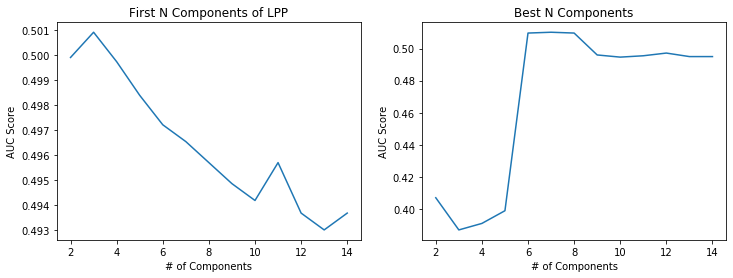

In [11]:
train_best, test_best = plot_AUCs(15, train_lpp, test_lpp, y_train_bi, 
                                  y_test_bi, 'First N Components of LPP', 
                                  best=True, stats = stats_lpp)

#### PCAs with different Kernels

##### RBF

In [12]:
train_rbf, test_rbf = get_components(KernelPCA,
                                     30, X_train,
                                     X_test, 'RBF',
                                     kernel='rbf')

healthy_rbf = train_rbf[train_rbf.index.isin(pos_ids)]
cancer_rbf = train_rbf[~train_rbf.index.isin(pos_ids)]

stats_rbf = get_stats(healthy_rbf, cancer_rbf)

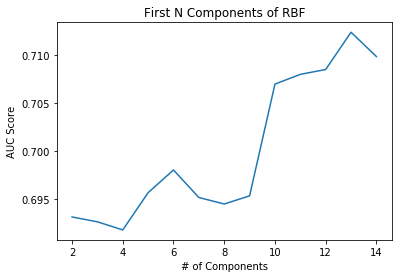

Max AUC:  0.7124050632911393


In [13]:
plot_AUCs(15, train_rbf, test_rbf, y_train_bi, 
          y_test_bi, 'First N Components of RBF')

##### Poly

In [14]:
train_poly, test_poly = get_components(KernelPCA,
                                     30, X_train,
                                     X_test, 'POLY',
                                     kernel='poly')

healthy_poly = train_poly[train_poly.index.isin(pos_ids)]
cancer_poly = train_poly[~train_poly.index.isin(pos_ids)]

stats_poly = get_stats(healthy_poly, cancer_poly)

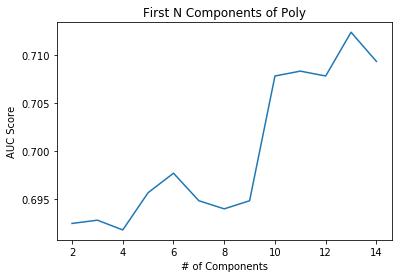

Max AUC:  0.7124050632911393


In [15]:
plot_AUCs(15, train_poly, test_poly, y_train_bi, 
          y_test_bi, 'First N Components of Poly')

##### Sigmoid

In [16]:
train_sig, test_sig = get_components(KernelPCA,
                                     30, X_train,
                                     X_test, 'SIG',
                                     kernel='sigmoid')

healthy_sig = train_sig[train_sig.index.isin(pos_ids)]
cancer_sig = train_sig[~train_sig.index.isin(pos_ids)]

stats_sig = get_stats(healthy_sig, cancer_sig)

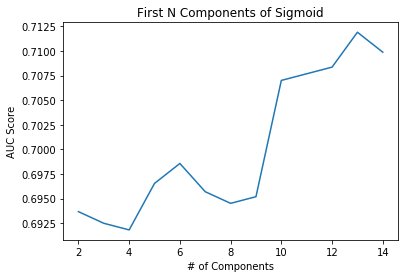

Max AUC:  0.7118987341772148


In [17]:
plot_AUCs(15, train_sig, test_sig, y_train_bi, 
          y_test_bi, 'First N Components of Sigmoid')

##### Cosine

In [18]:
train_cos, test_cos = get_components(KernelPCA,
                                     30, X_train,
                                     X_test, 'COS',
                                     kernel='cosine')

healthy_cos = train_cos[train_cos.index.isin(pos_ids)]
cancer_cos = train_cos[~train_cos.index.isin(pos_ids)]

stats_cos = get_stats(healthy_cos, cancer_cos)

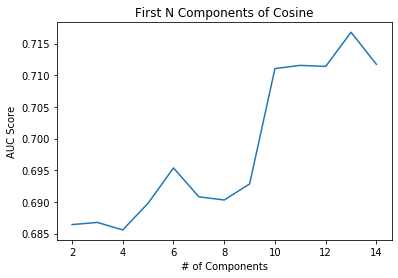

Max AUC:  0.7167932489451481


In [19]:
plot_AUCs(15, train_cos, test_cos, y_train_bi, 
          y_test_bi, 'First N Components of Cosine')

##### Linear (Ordinary) PCA

In [20]:
train_lin, test_lin = get_components(KernelPCA,
                                     30, X_train,
                                     X_test, 'Linear',
                                     kernel='linear')

healthy_lin = train_lin[train_lin.index.isin(pos_ids)]
cancer_lin = train_lin[~train_lin.index.isin(pos_ids)]

stats_lin = get_stats(healthy_lin, cancer_lin)

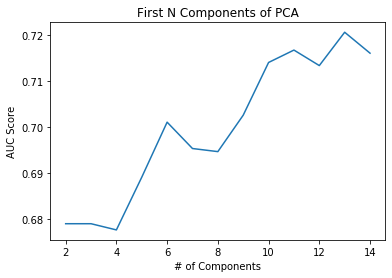

Max AUC:  0.7206751054852318


In [21]:
plot_AUCs(15, train_lin, test_lin, y_train_bi, 
          y_test_bi, 'First N Components of PCA')

#### FastICA

In [22]:
train_ica, test_ica = get_components(FastICA,
                                     30, X_train,
                                     X_test, 'ICA')

healthy_ica = train_ica[train_ica.index.isin(pos_ids)]
cancer_ica = train_ica[~train_ica.index.isin(pos_ids)]

stats_ica = get_stats(healthy_ica, cancer_ica)
stats_ica.head()
feat = stats_ica['Feature Name'][:10].values

Max AUC:  0.7252320675105485


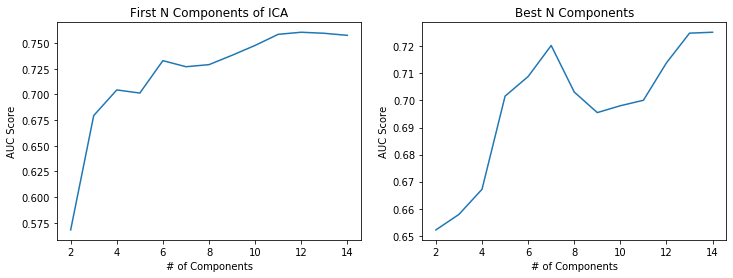

In [23]:
train_best, test_best = plot_AUCs(15, train_ica, test_ica, y_train_bi, 
                                  y_test_bi, 'First N Components of ICA', 
                                  best=True, stats=stats_ica)

In [24]:
df_train = train_best[feat]
df_train['IDs'] = df_train.index.values
df_test = test_best[feat]
df_test['IDs'] = df_test.index.values

## Local Binary Patterns
### Implementation

In [25]:
def get_lbp(temps,
            num_points=24,
            radius=2, hist=False):
    """Compute LBP features of the exloration's ROIs.

    If exploration is a patient ID, the LBPs are computed on the patient's
    latest exploration's ROIs.

    LBPs are masked with an eroded version of the ROI mask to reduce boundary
    artifacts due to the discontinuity of the ROI.

    Parameters
    ----------
    exploration: string or list
                 Patient ID or
                 list of ROI-masked temperatures in l, lf, r, rl order.
    num_points: int, optional
               Number of circularly symmetric neighbour set points
               (quantization of the angular space) of the LBP operator.

    readius: float, optional
             Radius of circle (spatial resolution of the LBP operator).

    Returns
    -------
    lbps: list[nd array]
          List of global LBP histograms of ROI-masked temperatures
          in l, lf, r, rl order.
    """
    if len(temps) != 4:
        raise ValueError('Not a valid exploration')

    lbps = []
    for temp in temps:
        # Obtain a masked array.
        temp_nan = temp.copy()
        temp_nan[~np.isnan(temp_nan)] = 1

        # Compute an eroded mask array to remove boundary effects
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        temp_nan_erode = np.nan_to_num(temp_nan)
        temp_nan_erode = cv2.erode(temp_nan_erode, kernel=kernel, iterations=3)
        temp_nan_erode[temp_nan_erode == 0] = np.nan
        # Compute lbp and histogram
        temp_lbp = local_binary_pattern(temp,
                                        P=num_points,
                                        R=radius,
                                        method='uniform')
        temp_lbp *= temp_nan_erode
        if hist:
            lbp_hist, _ = np.histogram(temp_lbp[~np.isnan(temp_lbp)],
                                       density=False, bins=10, range=(0, 10))
            lbp_hist = lbp_hist/(lbp_hist.sum() +  1e-10)
            lbps.append(lbp_hist)

        else:
            lbps.append(temp_lbp)
    if hist:
        breasts = int(len(lbps)/2)
        right = sum(lbps[:breasts])/len(lbps[:breasts])
        left = sum(lbps[breasts:])/len(lbps[breasts:])
        lbps = right- left
    return lbps

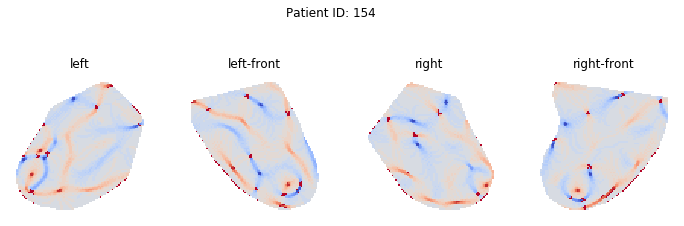

In [26]:
# Example LBPs
idx = np.random.choice(len(temps))
lbps = get_lbp(temps[idx])
plot_exp(lbps, IDs[idx])

In [27]:
lbp_data = [np.array(get_lbp(temp)).flatten() for temp in temps]

lbp_data = pd.DataFrame(lbp_data)
lbp_data.index = IDs

In [28]:
lbp_train = lbp_data[lbp_data.index.isin(df_train.index)].fillna(0)
lbp_test = lbp_data[lbp_data.index.isin(df_test.index)].fillna(0)

Max AUC:  0.6118143459915614


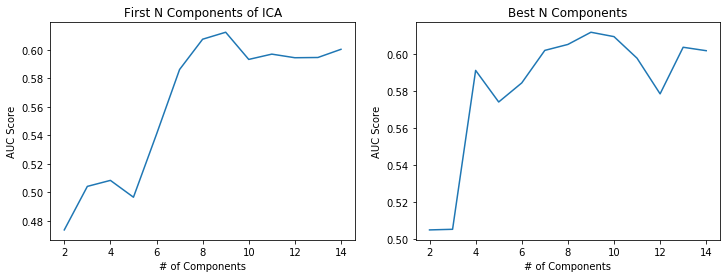

In [29]:
train_ica, test_ica = get_components(FastICA,
                                     15, lbp_train,
                                     lbp_test, 'LBP')

healthy_ica = train_ica[train_ica.index.isin(pos_ids)]
cancer_ica = train_ica[~train_ica.index.isin(pos_ids)]

stats_ica = get_stats(healthy_ica, cancer_ica)
feat = stats_ica['Feature Name'][:10].values

train_lbp, test_lbp = plot_AUCs(15, train_ica, test_ica, y_train_bi, 
                                y_test_bi, 'First N Components of ICA', 
                                best=True, stats=stats_ica)

In [30]:
lbp_train = train_lbp[feat]
lbp_train['IDs'] = lbp_train.index.values
lbp_test = test_lbp[feat]
lbp_test['IDs'] = df_test.index.values

df_train = pd.merge(df_train, lbp_train, how="left", on='IDs')
df_test = pd.merge(df_test, lbp_test, how="left", on='IDs')

## LBP-Based Delta-Ts

In [31]:
def temps_LBPs(loc, maxim, lbp_plot, inv):
    '''Plot temperature maps and their corresponding LBPs.'''
    f, ax = plt.subplots(nrows=1,
                     ncols=2,
                     figsize=(6,3))

    plt.tight_layout()
    ax[0].imshow(loc)
    m = np.argwhere(loc==maxim)
    m = list(zip(*m))

    ax[0].scatter(m[1], m[0])
    ax[0].axis('off')
    ax[1].imshow(loc)
    maxi = np.argwhere(loc==np.nanmax(loc))
    maxi = list(zip(*maxi))
    ax[1].scatter(maxi[1], maxi[0])
   
    ax[1].axis('off')
    f.suptitle('Delta-Ts vs. Max Temp')
    plt.show()

In [32]:
def select_hot(fr, lat, other_lat, other_fr, lbp_fr, lbp_lat, viz=False):
    ''' Map LBPs to temps in the breast and identify the highest temp.'''
    if np.nanmax(fr[lbp_fr==np.nanmin(lbp_fr)]) >= np.nanmax(lat[lbp_lat ==np.nanmin(lbp_lat)]):
        maxim = np.nanmax(fr[lbp_fr ==np.nanmin(lbp_fr)])
        loc = fr
        inv = other_fr
        lbp_plot = lbp_fr
    else:
        maxim = np.nanmax(lat[lbp_lat ==np.nanmin(lbp_lat)])
        loc = lat
        inv = other_lat
        lbp_plot = lbp_lat
    
    if viz: 
        temps_LBPs(loc, maxim, lbp_plot, inv)
    return maxim, loc, inv

def avg_area(array, inds):
    ''' 
    Calculate the average temperature in the corresponding
    area of the other breast.
    '''
    for n in range(5,60,5):
        start = [max(0, inds[0]-n), max(0, inds[1]-n)]
        fin = [min(array.shape[0]-1,inds[0]+n), 
               min(array.shape[1]-1,inds[1]+n)]
        if fin[0] < start[0] or fin[1] < start[1]:
            continue
        f = np.nanmean(array[start[0]:fin[0], start[1]:fin[1]])
        if np.isnan(f):
            continue
        break
    return f

def temp_diff(temps_l, temps_lf, temps_r, temps_rf,
              lbp_l, lbp_lf, lbp_r, lbp_rf, viz=False, ID=None):
    ''' Calculate delta-T. '''
    # Select the hottest area  
#     print(ID)
    max_r, loc_r, inv_r = select_hot(temps_rf, temps_r,
                                     temps_l, temps_lf,
                                     lbp_rf, lbp_r, viz)
    max_l, loc_l, inv_l = select_hot(temps_lf, temps_l, 
                                     temps_r, temps_rf, 
                                     lbp_lf, lbp_l, viz=False)
    
    # Calculate the difference in temperatures
    if max_r > max_l:
        ind = np.array(np.where(loc_r == max_r)).T[0]
        other_side = avg_area(np.flip(inv_r, axis=1), ind)
        therm = loc_r[ind[0]][ind[1]] - other_side           
    else:
        ind = np.array(np.where(loc_l == max_l)).T[0]
        other_side = avg_area(np.flip(inv_l, axis=1), ind)
        therm = loc_l[ind[0]][ind[1]] - other_side            
    return therm
    

In [33]:
lbp_full = [get_lbp(temp) for temp in temps]

In [34]:
lbp_deltas=[temp_diff(temps[i][0], temps[i][1], temps[i][2], temps[i][3], viz=False,
                      lbp_l=lbp_full[i][0], lbp_lf=lbp_full[i][1], 
                      lbp_r=lbp_full[i][2], lbp_rf=lbp_full[i][3], ID = IDs[i]) for i in range(len(temps))]

deltas = pd.DataFrame({'IDs': IDs, 'lbp_deltas': lbp_deltas})
df_train = pd.merge(df_train, deltas, how="left", on='IDs')
df_test = pd.merge(df_test, deltas, how="left", on='IDs')

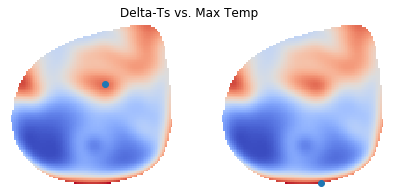

In [35]:
# Illustrate why delta-T is better
lbp = get_lbp(temps[1])
img = temp_diff(temps[1][0],temps[1][1],
                temps[1][2],temps[1][3], 
                viz=True, lbp_l=lbp[0], 
                lbp_lf=lbp[1], lbp_r=lbp[2],
                lbp_rf=lbp[3], ID=IDs[idx])

## Segmentation Features

In [36]:
# Create clahe object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def snake_format(images):
    ''' 
    Put images into a format suitable for the Snake package:
    
    - Add a small value to zero values to ensure we still get
    numerical values when converting 0s to NaNs
    - Convert image pixels into a range from 0 to 255
    - Put them in the uint8 format
    - Apply clahe
    '''
    new_images = []
    # Find max and min
    gl_min = np.nanmin(np.array(images))
    gl_max =  np.nanmax(np.array(images))
    for image in images:
        # Add small numeric values
        image = image - np.nanmin(image) + 0.08
        image = np.nan_to_num(image/np.nanmax(image))
        # Apply clahe
        image = clahe.apply(np.asarray(image*255, dtype = np.uint8))
        image[image==4] = 0
        new_images.append(image)
    return new_images

def plot_res(images, masks, pid, white=False):
    ''' Plot the four images with the corresponding masks and the PID.'''
    # Put them into the order that corresponds to raw images
    fig, ax = plt.subplots(1, 4,figsize=(12,8))
    titles = ['left', 'left-front', 'right', 'right-front']
    for i in range(len(images)):
        # Plot images
        images[i][images[i]==0]=np.nan
        ax[i].imshow(masks[i], 'gray') 
        ax[i].set_title(titles[i])
        ax[i].imshow(images[i], alpha=0.8)
        ax[i].axis('off')
    

    plt.show()

In [37]:
# Get masks and erode them
def erode_masks(image, segments, random_walk=False):
    ''' Get final segmented images (0-1 masks) by applying erosion. '''
    kernel = np.ones((2, 2), np.uint8)
    if random_walk:
        segments = np.where(segments == 2, True,False)

    segments[np.isnan(segments)]=0
    # Erode masks to make sure we're not covering edges
    segments = cv2.erode(segments.astype('uint8'), 
                         kernel, iterations = 3).astype('bool')
    return np.where(segments==0, np.nan, 1)

def get_chan(image):
    ''' Get Chan-Vese segmented images. (Was only used for original comparison) '''
    segments = seg.chan_vese(image,lambda1=5,lambda2=1,
                         init_level_set = 'small disk',
                         mu =0.005, max_iter=1000,)
    return erode_masks(image, segments)
    

def get_random(image, erode=False):
    ''' Get random walker segmented images. '''
    markers = np.zeros(image.shape, dtype=np.uint)
    markers[image < 0.99*(np.max(image))] = 1
    markers[image > 0.60*(np.max(image))] = 2

    # Run random walker algorithm
    segments = seg.random_walker(image, markers, beta=10, mode='bf')
    return erode_masks(image, segments, True)

def get_masks(temps, func=get_random):
    ''' Combine preprocessing and segmentation. '''
    new_temps = snake_format([temps[0], temps[1], temps[2], temps[3]])
    return [func(temp) for temp in new_temps]

In [38]:
def get_prop(image, function):
    ''' Get the proportion of the image covered by the mask. '''
    # Find segmented vascular areas
    vasc = function(image) 
    # Turn zeros to nans
    image = image.astype('float')
    image[image==0]=np.nan
    # Return the proportion
    return np.count_nonzero(~np.isnan(vasc)) / np.count_nonzero(~np.isnan(image))

In [39]:
def vasc_score(temps_l, temps_lf, 
              temps_r, temps_rf, 
              function = get_random):
    ''' Calculate vascularity as defined in Gonzalez (2011). '''
    new_temps = snake_format([temps_l, temps_lf, temps_r, temps_rf])
    left = get_prop(new_temps[0], function)
    left += get_prop(new_temps[1],function)
    left /= 2
    
    right = get_prop(new_temps[2], function)
    right += get_prop(new_temps[3], function)
    right /= 2
    
    # Experimentally found values that have high correlation to Javier's scores
    if left<0.46 and right<0.46:
        return 1
    elif np.abs(left-right) < 0.2:
        return 2
    elif left>0.57 or right>0.57:
        return 4
    else:
        return 3

In [40]:
vascularity = [vasc_score(temps_l=temp[0], 
                   temps_lf=temp[1], 
                   temps_r=temp[2], 
                   temps_rf=temp[3]) for temp in temps]


vascularity = pd.DataFrame({'IDs': IDs, 'vasc': vascularity})
df_train = pd.merge(df_train, vascularity, how="left", on='IDs')
df_test = pd.merge(df_test, vascularity, how="left", on='IDs')

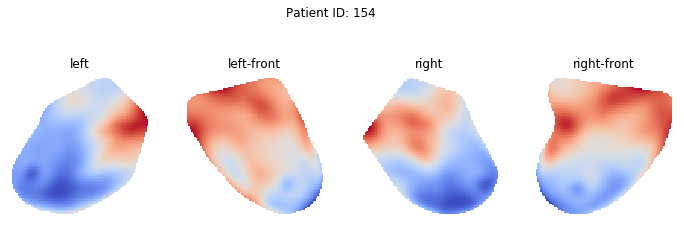

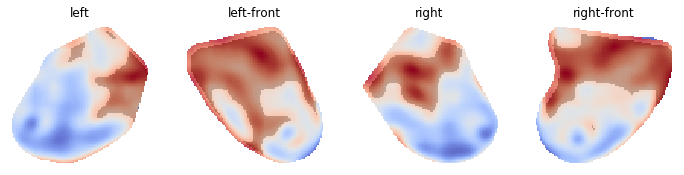

In [41]:
plot_exp(temps[idx], IDs[idx])
new_temps = snake_format([temps[idx][0],temps[idx][1],temps[idx][2],temps[idx][3]])
images = [temp for temp in new_temps]
labels = [get_random(image) for image in images]
images = [image.astype('float') for image in images]

plot_res(images, labels, IDs[idx])

## Analysis

In [42]:
df_train.index = df_train.IDs.values
df_train = df_train.drop(columns=['IDs'])
df_test.index = df_test.IDs.values
df_test = df_test.drop(columns=['IDs'])

In [43]:
# Get automated thermal score values
TS_train = (df_train['lbp_deltas'].values + df_train['vasc'].values).reshape(-1,1)
TS_test = (df_test['lbp_deltas'].values + df_test['vasc'].values).reshape(-1,1)

# Get different subsets of engineered features
hog_train = df_train.filter(regex='ICA')
hog_test = df_test.filter(regex='ICA')

lbp_train = df_train.filter(regex='LBP')
lbp_test = df_test.filter(regex='LBP')

0.7154430379746836

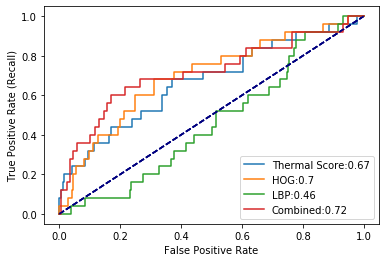

In [44]:
# Evaluate performance
performance(TS_train, y_train_bi, TS_test, y_test_bi, detailed = True, title='Thermal Score')
performance(hog_train, y_train_bi, hog_test, y_test_bi, detailed = True, title='HOG')
performance(lbp_train, y_train_bi, lbp_test, y_test_bi, detailed = True, title='LBP')
performance(df_train, y_train_bi, df_test, y_test_bi, detailed = True, title='Combined')

In [45]:
df_train['BIRADS'] = y_train
df_test['BIRADS'] = y_test
df_train.to_csv('train_data.csv')
df_test.to_csv('test_data.csv')